## Import

In [293]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

from tqdm import tqdm

#데이터 증강기법 활용을 위한 라이브러리 임포트
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, HorizontalFlip, Rotate, RandomBrightnessContrast,
    Resize, Normalize)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [194]:
DATA_DIR = './open'

x_train_dir = os.path.join(DATA_DIR, 'train_source_image')
y_train_dir = os.path.join(DATA_DIR, 'train_source_gt')

x_valid_dir = os.path.join(DATA_DIR, 'val_source_image')
y_valid_dir = os.path.join(DATA_DIR, 'val_source_gt')

x_test_dir = os.path.join(DATA_DIR, 'test_image')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')


In [195]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Utils

In [196]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [281]:
class Dataset(BaseDataset):
    CLASSES = ['Road', 'Sidewalk', 'Construction', 'Fence', 'Pole', 
               'Traffic Light', 'Traffic Sign', 'Nature', 'Sky', 
               'Person', 'Rider', 'Car']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            infer=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

        if masks_dir:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None
            
        self.infer = infer
        
        # If classes are not provided, default to all classes
        if not classes:
            classes = self.CLASSES

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.title()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Check if masks_fps is not None
        mask = None
        if self.masks_fps:
            mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
            # adjust mask values for 'unlabelled' class
            mask[mask == 255] = 12

        # apply augmentations
        if self.augmentation:
            if mask:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.augmentation(image=image)['image']

        # apply preprocessing
        if self.preprocessing:
            if mask:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.preprocessing(image=image)['image']

        return (image, mask) if mask is not None else image


        if self.infer:
            if self.augmentation:
                image = self.augmentation(image=image)['image']
            
    def __len__(self):
        return len(self.ids)


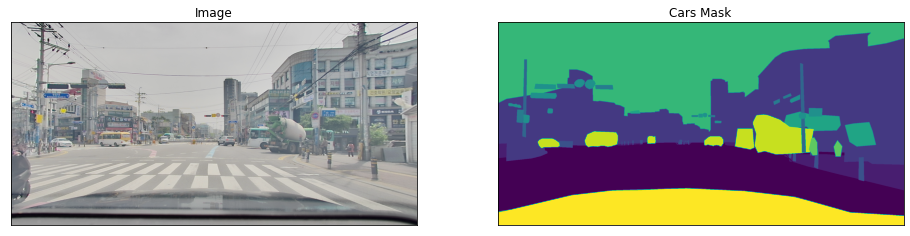

In [282]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [284]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        albu.RandomCrop(height=224, width=224, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape 224x224"""
    test_transform = [
        albu.PadIfNeeded(224, 224),
        albu.CenterCrop(height=224, width=224, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    elif len(x.shape) == 2:
        return x.astype('float32')
    else:
        raise ValueError("Invalid array shape!")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [285]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation()
)
print(images.shape)
print(masks.shape)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask)

torch.Size([2, 3, 224, 224])
torch.Size([2, 224, 224])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [219]:
import sys

# 원하는 디렉토리 경로 추가
sys.path.append('/home/work/CPS_Project/Samsung AI-Challenge')

# 모듈 임포트
# from utils import your_util_function  # 필요한 함수 또는 클래스를 임포트

# 이제 해당 모듈의 함수나 클래스를 사용할 수 있습니다.

In [220]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [253]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 13
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=NUM_CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
print(model)

In [261]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [286]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

for images, masks in valid_loader:
    print(images.shape, masks.shape)
    break

torch.Size([16, 3, 224, 224]) torch.Size([16, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 224, 224])


In [287]:
mask_path = "/home/work/CPS_Project/Samsung AI-Challenge/open/train_source_gt/TRAIN_SOURCE_0024.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unique_values = np.unique(mask)
print(unique_values)

[  0   1   2   3   4   6   7   8  11 255]


In [271]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

device = DEVICE
criterion = torch.nn.CrossEntropyLoss()

In [297]:
# IoU 계산 함수
def iou_score(output, target):
    smooth = 1e-5

    n_classes = output.shape[1]
    ious = []

    for cls in range(n_classes):
        cls_output = output[:, cls, :, :]
        cls_target = (target == cls).float()

        intersection = (cls_output * cls_target).sum()
        union = cls_output.sum() + cls_target.sum() - intersection

        ious.append((intersection + smooth) / (union + smooth))

    return sum(ious) / len(ious)

# 초기 설정
best_miou = 0
save_path = './Samsung_best_model.pth'

# 학습 루프
for epoch in range(2):
    model.train()
    epoch_loss = 0
    total_iou = 0

    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_iou += iou_score(outputs.detach(), masks.squeeze(1).detach())

    avg_miou = total_iou / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, mIoU: {avg_miou}')
    
    # Validation and Save best model
    model.eval()
    total_val_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.float().to(device)
            masks = masks.long().to(device)
            outputs = model(images)
            total_val_iou += iou_score(outputs, masks.squeeze(1))
    avg_val_miou = total_val_iou / len(valid_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(valid_loader)}, mIoU: {avg_val_miou}')
    print(f'Validation mIoU: {avg_val_miou}')

    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(model.state_dict(), save_path)
        print(f'Model saved at {save_path} with mIoU: {best_miou}')

    # 50 epochs마다 learning rate 조정
    if (epoch+1) % 50 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f'Learning rate reduced to {param_group["lr"]}')


100%|██████████| 138/138 [01:01<00:00,  2.26it/s]


Epoch 1, Loss: 1.8169942861017974, mIoU: 0.35415199398994446


100%|██████████| 466/466 [00:17<00:00, 26.58it/s]


Epoch 1, Loss: 0.5380798529657683, mIoU: 0.22825586795806885
Validation mIoU: 0.22825586795806885
Model saved at ./Samsung_best_model.pth with mIoU: 0.22825586795806885


100%|██████████| 138/138 [01:00<00:00,  2.28it/s]


Epoch 2, Loss: 1.8130626220634019, mIoU: 0.3529195487499237


100%|██████████| 466/466 [00:17<00:00, 26.77it/s]


Epoch 2, Loss: 0.5369155404393765, mIoU: 0.22863087058067322
Validation mIoU: 0.22863087058067322
Model saved at ./Samsung_best_model.pth with mIoU: 0.22863087058067322


In [273]:
for epoch in range(2):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')

100%|██████████| 138/138 [01:00<00:00,  2.27it/s]


Epoch 1, Loss: 1.8960674431013025


100%|██████████| 138/138 [01:00<00:00,  2.27it/s]

Epoch 2, Loss: 1.8432287202365156


In [265]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [288]:
with torch.no_grad():
    model.eval()
    images = images.to('cuda')  
    outputs = model(images)
    print(outputs.shape)
    

torch.Size([1, 13, 224, 224])


In [267]:
# train model for 20 epochs

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './Samsung_best_model4.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/138 [00:04<?, ?it/s]


RuntimeError: The size of tensor a (16) must match the size of tensor b (13) at non-singleton dimension 1

In [298]:
# load best saved checkpoint
best_model = torch.load('./Samsung_best_model.pth')

## Inference

In [299]:
test_dataset = Dataset(
    x_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    infer=True,
)

#test_dataset = CustomDataset(csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [300]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]/tmp/ipykernel_142164/4045914463.py:13: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
100%|██████████| 119/119 [00:52<00:00,  2.27it/s]


## Submission

In [301]:
submit = pd.read_csv('/home/work/CPS_Project/Samsung AI-Challenge/open/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,335 17 1295 17 2204 26 2238 52 3164 26 3198 52...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,-1
3,TEST_0000_class_3,-1
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,-1
22772,TEST_1897_class_8,-1
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [292]:
submit.to_csv('./baseline_submit_8(New_Model).csv', index=False)